# 1: Import Packages and Define Functions

In [119]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod5/Emoji_Analysis/Scripts/')
import config
import warnings
warnings.filterwarnings('ignore')



pd.set_option('display.max_columns', 300)

%matplotlib inline

In [120]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import string
import scipy
import emoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [121]:
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI)

In [122]:
def check_for_flags(s):
    s = str(s)
    has_flag = False
    for flag in flags:
        if flag in s:
            has_flag = True
    return has_flag

In [123]:
def unique_emoji_count(s):
    return len(set([c for c in s]))

In [124]:
def condence_emojis(s):
    try:
        return set(s).pop()
    except:
        return None

In [125]:
analyzer = SentimentIntensityAnalyzer()
def sentiment_scores(s):
    return analyzer.polarity_scores(s)['compound']

In [126]:
def remove_emojis(s):
    pattern = "[@\w]+"
    return ' '.join(re.findall(pattern, s))

# 2: Load in the Data and Clean

In [127]:
connection = mysql.connector.connect(host=config.host,
                                         user=config.user,
                                         port=config.port,
                                         password=config.password,
                                         database=config.database,
                                         auth_plugin='mysql_native_password')

cursor = connection.cursor()
query = "SELECT tweet FROM Election_Tweets WHERE HEX(tweet) RLIKE '^(..)*F.'"

df = pd.read_sql(query, connection)

In [128]:
df.head()

,tweet
0,2 days until the election or 2 days until mass...
1,"@Brianclowdus In keeping with your love of ""sl..."
2,@Bull_Spotter Had a feeling the EU wanted to s...
3,@HeidiNBC Volunteer poll workers are the unsun...
4,@jaketapper Hmm 🤔 how about those republicans ...


In [129]:
df['emoji'] = df.tweet.apply(extract_emojis)

In [130]:
# We can see that emoji flags have strange representations. I will remove them from the dataset.
## NOTE BELOW LIKELY WILL NO LONGER SHOW A FLAG, SINCE I'VE BEEN PULLING DATA EVERY DAY
## But, flags were basically as follows....alone as a string, they are equal to a flag plus a white space
## HOWEVER, once you strip it apart into a list form, it becomes a list of two emoticon-characters
## For example, Brazil Flag as a string is "Flag ", but as a list, it is ["[B], [R]"]
## Below, i actually acquire these codes from wikipedia to aid in removing flags from the dataset
[c for c in df.emoji.loc[9]]

['💥', '💥', '👍']

In [131]:
import flag
from bs4 import BeautifulSoup
import requests

In [132]:
url = 'https://en.wikipedia.org/wiki/Regional_indicator_symbol'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

In [133]:
flags = []
skip_first = 0
for item in soup.find('tbody').find_all('tr'):
    if skip_first == 0:
        skip_first += 1
        continue
    flagcode = item.find_all('td')[1].text
    flags.append(flag.flag(flagcode))

flags[0:5]    

['🇦🇨', '🇦🇩', '🇦🇪', '🇦🇫', '🇦🇬']

In [134]:
df.emoji.apply(check_for_flags).value_counts()

False    126
True      16
Name: emoji, dtype: int64

In [135]:
df['has_flag'] = df.emoji.apply(check_for_flags)
df = df[df.has_flag == False]
df.drop('has_flag', axis=1, inplace=True)

In [136]:
df['unique_emoji_count'] = df.emoji.apply(unique_emoji_count)

In [137]:
df['sentiment_score'] = df.tweet.apply(sentiment_scores)

In [138]:
df.to_csv("tweets_w_all_emojis_present.csv")

In [139]:
df.head()

,tweet,emoji,unique_emoji_count,sentiment_score
0,2 days until the election or 2 days until mass...,🤔,1,-0.2960
1,"@Brianclowdus In keeping with your love of ""sl...",😉🤣😎,3,0.8860
2,@Bull_Spotter Had a feeling the EU wanted to s...,😁,1,0.8658
3,@HeidiNBC Volunteer poll workers are the unsun...,✨🤜🤛✨,3,0.8149
4,@jaketapper Hmm 🤔 how about those republicans ...,🤔,1,-0.5423


In [140]:
pattern = "[@\w]+"
' '.join(re.findall(pattern, df.tweet.iloc[2]))

'@Bull_Spotter Had a feeling the EU wanted to stretch talks out until after US election result I ll smile when Trump wins'

In [141]:
df['tweet'] = df.tweet.apply(remove_emojis)

In [142]:
df.head()

,tweet,emoji,unique_emoji_count,sentiment_score
0,2 days until the election or 2 days until mass...,🤔,1,-0.2960
1,@Brianclowdus In keeping with your love of sle...,😉🤣😎,3,0.8860
2,@Bull_Spotter Had a feeling the EU wanted to s...,😁,1,0.8658
3,@HeidiNBC Volunteer poll workers are the unsun...,✨🤜🤛✨,3,0.8149
4,@jaketapper Hmm how about those republicans Ja...,🤔,1,-0.5423


In [143]:
df.emoji.isna().sum()

0

In [144]:
df.dropna(inplace=True)

In [145]:
df.isna().sum()

tweet                 0
emoji                 0
unique_emoji_count    0
sentiment_score       0
dtype: int64

In [146]:
df = df[df.unique_emoji_count > 0]

In [147]:
df.reset_index(inplace=True)

In [148]:
# Creating a dataframe of singular emojis to the average sentiment score they obtain
df2 = df.copy()
df2 = df2[df2.unique_emoji_count == 1]
df2['emoji'] = df2.emoji.apply(condence_emojis)
emoji_sentiment_mappings = df2[['emoji', 'sentiment_score']].groupby('emoji').mean()

In [149]:
def impute_top_emoji(s, mappings = emoji_sentiment_mappings, data = df):
    val = df[df.emoji == s].sentiment_score.values[0]
    s = list(set(s))
    closest = 100
    top = s[0]
    for i in range(0, len(s)):
        try:
            if abs(val - emoji_sentiment_mappings.loc[s[i]].sentiment_score) < closest:
                closest = abs(val - emoji_sentiment_mappings.loc[s[i]].sentiment_score)
                top = s[i]
        except:
            continue
    return top

In [150]:
df['top_emoji'] = df.emoji.apply(impute_top_emoji)

In [151]:
df.drop(["unique_emoji_count", "emoji"], axis=1, inplace=True)
df.drop('index', axis=1, inplace=True)

In [152]:
emoji_counts = dict(df.top_emoji.value_counts())

In [153]:
df['emoji_frequency'] = df.top_emoji.map(emoji_counts)

In [154]:
df.head()

,tweet,sentiment_score,top_emoji,emoji_frequency
0,2 days until the election or 2 days until mass...,-0.2960,🤔,2
1,@Brianclowdus In keeping with your love of sle...,0.8860,😎,1
2,@Bull_Spotter Had a feeling the EU wanted to s...,0.8658,😁,1
3,@HeidiNBC Volunteer poll workers are the unsun...,0.8149,🤛,1
4,@jaketapper Hmm how about those republicans Ja...,-0.5423,🤔,2


In [155]:
df.to_csv("tweets.csv")

# 3. Explore the Data and Create Initial Insights

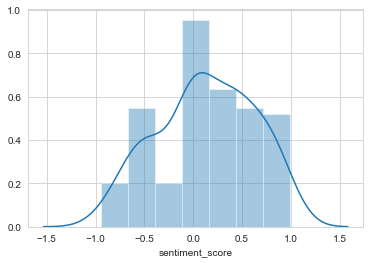

In [156]:
sns.distplot(df.sentiment_score)

### Write in some blurb here about the stuff above (amount of emojis, mean freq of emoji, etc) once I have all my data

In [157]:
emojis = df.groupby('top_emoji').mean()

In [158]:
neg_emojis = emojis[emojis.sentiment_score < -.1].index.unique()
net_emojis = emojis[(emojis.sentiment_score >= -.1) & (emojis.sentiment_score <= .1)].index.unique()
pos_emojis = emojis[emojis.sentiment_score > .1].index.unique()

In [159]:
negative = df.loc[df['top_emoji'].isin(neg_emojis)]
neutral = df.loc[df['top_emoji'].isin(net_emojis)]
positive = df.loc[df['top_emoji'].isin(pos_emojis)]

print(f"Negative length: {len(negative)}")
print(f"Neutral length: {len(neutral)}")
print(f"Postive length: {len(positive)}")

Negative length: 35
Neutral length: 28
Postive length: 62


In [160]:
negative.top_emoji.value_counts()[:20]

😭    4
🙄    3
🤔    2
🔥    2
💥    2
💩    2
😫    2
🥴    2
🤷    2
🎉    2
😬    2
🤯    1
😑    1
😖    1
🤬    1
😪    1
🤞    1
🤨    1
😱    1
😲    1
Name: top_emoji, dtype: int64

In [161]:
neutral.top_emoji.value_counts()[:20]

🚨    15
👇     3
🏽     2
🤦     2
🎶     1
🏻     1
🙅     1
👏     1
😏     1
🔔     1
Name: top_emoji, dtype: int64

In [162]:
positive.top_emoji.value_counts()[:20]

😂    9
🙏    7
🗳    6
😳    4
👀    3
🥰    2
😅    2
💕    2
🧐    2
📍    2
💃    2
🏀    2
👉    1
🍀    1
😀    1
🐻    1
🖐    1
🙂    1
🤛    1
😎    1
Name: top_emoji, dtype: int64

From the above, I will select some emojis to have as my "target values". My model won't be able to predict any emoji from the entire list of them, as that would greatly increase the difficulty of the classification. Would likely need far, far more data than I have for each emoji in order for something like that to work.

I will choose emojis based on the following:
- Emojis with highest usage count
- Emojis that cover aspects from the groups above
- My light KMeans coverage points to 6, 7 or 8 classes

Target 1 (General vibe of laughter)
- 😂   (most frequent per twitter article, will convert below to this using np.where)
- 🤣

Target 2 (General vibe of loving)
- 😍   (most frequent per twitter article, will convert below to this using np.where)
- 🥰
- 🥺

Target 3 (General vibe of anger -- note the counts for this are quite low from my search results)
- 😡   (most frequent per twitter article, will convert below to this using np.where)
- 😤
- 🤬
- 😠


Target 4 (General vibe of sad)
- 😭   (most frequent per twitter article, will convert below to this using np.where)
- 😢
- 😫
- 😞

Target 5 (General vibe of happy)
- 😊   (most frequent per twitter article, will convert below to this using np.where)
- 😁
- 😌

Target 6 (General vibe of scary/nervous)
- 😱   (Most frequent fearful emoji face,  will convert below to this using np.where)
- 👻   (Note, this emoji is most likely extra prevalent due to the fact data was gathered days before halloween)
- 😬


Target 7 (General vibe of wonder/puzzled)
- 🤔   (most frequent per twitter article, will convert below to this using np.where)
- 🙄   
- 😳
- 🧐





In [ ]:
test = ['😂', '🤣', '😍', '🥰','🥺', '😡', '😤','🤬','😠','😭','😢','😫','😞',
       '😊', '😁','😌','😱', '👻','😬','🤔', '🙄', '😳', '🧐']

In [42]:
new_df = df[df.top_emoji.isin(test)]

In [43]:
conditions = [
    new_df.top_emoji == '🤣',
    (new_df.top_emoji == '🥰') | (new_df.top_emoji == '🥺'),
    (new_df.top_emoji == '😤') | (new_df.top_emoji == '🤬') | (new_df.top_emoji == '😠'),
    (new_df.top_emoji == '😢') | (new_df.top_emoji == '😫') | (new_df.top_emoji == '😞'),
    (new_df.top_emoji == '😁') | (new_df.top_emoji == '😌'),
    (new_df.top_emoji == '👻') | (new_df.top_emoji == '😬'),
    (new_df.top_emoji == '🙄') | (new_df.top_emoji == '😳') | (new_df.top_emoji == '🧐')
]

choices = [
    '😂',
    '😍',
    '😡', 
    '😭',
    '😊', 
    '😱', 
    '🤔'
]

new_df.top_emoji = np.select(conditions, choices, default = new_df.top_emoji)

In [44]:
new_df.top_emoji.value_counts()

😂    13949
😭     8719
😍     7192
🤔     3740
😊     3230
😱     2477
😡     1155
Name: top_emoji, dtype: int64

In [45]:
list(new_df.top_emoji.value_counts().index)

['😂', '😭', '😍', '🤔', '😊', '😱', '😡']

In [46]:
new_df.drop('emoji_frequency', axis=1, inplace=True)

In [47]:
freq_map = dict(new_df.top_emoji.value_counts())
new_df['emoji_frequency'] = new_df.top_emoji.map(freq_map)

In [48]:
emojis = new_df.groupby('top_emoji').mean()

In [49]:
emojis.to_csv("emojis.csv")

In [50]:
new_df.to_csv("tweets_7_classes.csv")

In [51]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path):
    return OffsetImage(plt.imread(path))

In [52]:
emojis.index

Index(['😂', '😊', '😍', '😡', '😭', '😱', '🤔'], dtype='object', name='top_emoji')

In [53]:
pics = ['laugh.png', 'happy.png','love.png','angry.png','cry.png','scary.png','wonder.png']

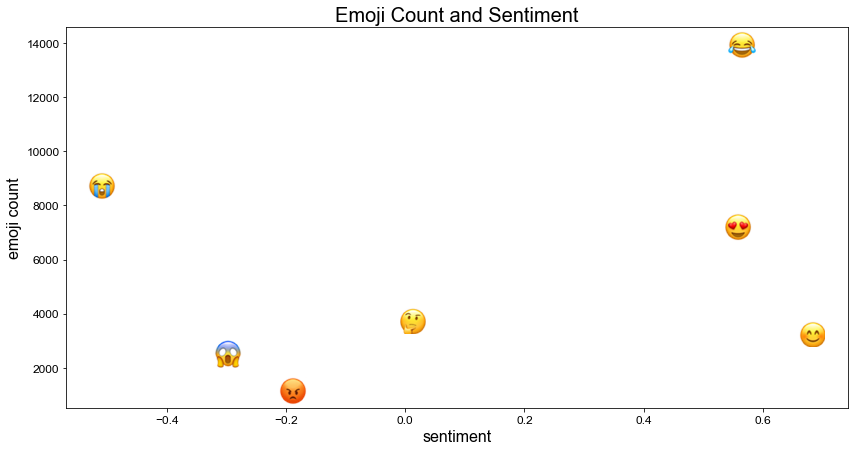

In [54]:
fig, ax = plt.subplots(figsize = (14,7))

sns.scatterplot(x=emojis.sentiment_score, y=emojis.emoji_frequency, ax=ax)
sns.set_style("whitegrid")
plt.xticks(fontsize=12)
plt.xlabel('sentiment', fontsize=16)
plt.yticks(fontsize=12)
plt.ylabel('emoji count', fontsize=16)
plt.title("Emoji Count and Sentiment", fontsize = 20)

for x0, y0, pic in zip(emojis.sentiment_score, emojis.emoji_frequency,pics):
    ab = AnnotationBbox(getImage(pic), (x0, y0), frameon=False)
    ax.add_artist(ab)
plt.show()

In [56]:
new_df

,tweet,sentiment_score,top_emoji,emoji_frequency
0,Hello this has been KARINA and WINTER We re cu...,0.9840,😊,3230
1,ilysm you deserve the world please you re awes...,0.7284,😍,7192
4,Hey 965TDY I d like to hear Naughty List by li...,0.9168,😊,3230
6,If I were to lift her up I d die SingleAndMing...,0.9723,😂,13949
7,Mr Blair don t be a lier a Blier R G Mugabe RI...,0.4404,😂,13949
...,...,...,...,...
115864,Says the person who is able to walk past the d...,0.9911,😂,13949
115865,10 10 comedy https t co BqwVhDbZx8,0.9983,😂,13949
115866,Liverpool fans kill me clowns https t co Bbtk1...,0.9972,😂,13949
115867,DEEP BREATH https t co csZ66nGIAz,0.9991,😂,13949
